In [1]:
from ai4h.models import embeddings 
from pathlib import Path
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.decomposition import PCA

## Embeddings

Load text embeddings using the load_txt_embeddings method from embeddings module. 

The vocabulary is a list of strings, i.e. the vocabulary of the dataset. The vectors are the numerical representation of these words e.g. in this example in the 50 dimensional space. Such that each word in the vocabulary has a numerical representation in $ \mathbb{R}^{50}$. How these are constructed can differ, word2vec, GloVe uses a giant word-word co-occurence matrix i.e. count how often a word $i$ appears near word $j$, and then some weigthed loss function that says the dot product of two embeddings $w_i^\prime c_j$ should approximate $\log X_{ij}$. 

We normalize the embeddings due to cosine-similarity. A given vector has two properties, direction and length. The direction encodes semantic information (what clusters the word is in). Length can be influenced by frequency (common words will often get bigger norms). When we want to compare meanings via cosine similarity

$$ \cos(v,w) = \frac{v^\prime w}{||v|| \cdot ||w||}, $$

we are essentially asking "How aligned are these vectors, regardless of their length?". Then by normalizing (divide the vector by its norm) we make the dot product = cosine similarity. This in turn makes nearest neighbor (or TSNE in this case) efficient, and less sensitive to word frequency. 

In [2]:
# Using path lib set the data dir which is in a subfolder of a subfolder of the current working directory
data_dir = Path.cwd().parent / "src" / "data"

vocab, vectors = embeddings.load_txt_embeddings(data_dir / "wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt", max_vocab= 100000)

vectors_norm = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

t-distributed nearest neighbor embedding (TSNE) is a nonlinear dimensionality reduction method, which allows us to visualize these high dimensional embeddings. 

In [3]:
vectors_2d = TSNE(n_components=2, random_state=0).fit_transform(vectors_norm[:1000])
# X_embedded = tsne.fit_transform(vectors_norm)
# vectors_2d = tsne.fit_transform(vectors_norm)

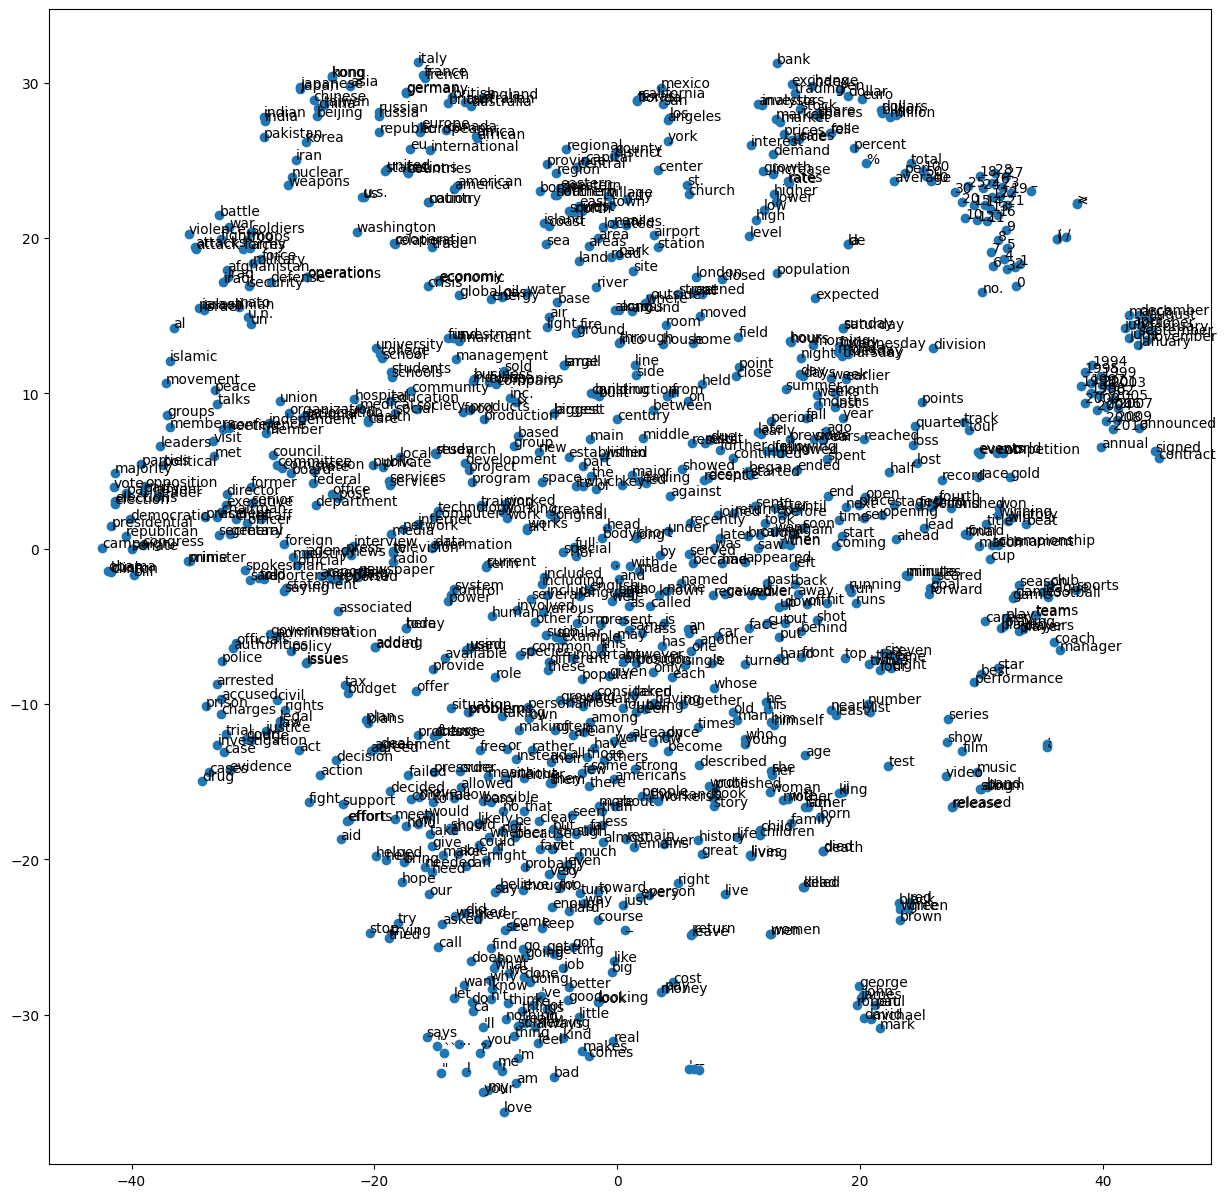

In [4]:
n_plot = 1000 
xs, xy = vectors_2d[:n_plot, 0], vectors_2d[:n_plot, 1]
plt.figure(figsize=(15, 15))
plt.scatter(xs, xy)

for i, word in enumerate(vocab[:n_plot]):
    plt.annotate(word, (xs[i], xy[i]))

#plt.show()

The plot directly visualize these clusters, which are to represent how similar the words are. To the left midlle we see a clear cluster of stuff related to jucidal language. This extends to the 50 dimensional space, if words are close in the above 2D space, they are close in the 50D space. 

Another way to describe it is that words close to eachother have distributional similarity -> words appear in similar contexts in the training corpus. 

The corpus however contain human biases -> and in turn embeddings do as well. 

Embeddings are usefull because they capture semantic proximity without needing explicit rules. 

In [5]:
emb = embeddings.WordEmbeddings(unit_vectors=vectors_norm, vocab=vocab)

print(emb.word2idx["king"])  # should print 703 if "king" is vocab[703]
print(emb.unit_vectors[emb.word2idx["king"]])  # the actual embedding vector

703
[-0.06431497  0.14318627  0.11292296 -0.12502973  0.2541763  -0.3308853
 -0.01780349  0.20785823  0.04286857 -0.0968387   0.19253564  0.03568151
  0.11756944 -0.08489534 -0.08767682 -0.04134195  0.04494479  0.06933231
  0.06959268  0.04481419  0.04683105  0.03425036 -0.16674022  0.02965648
  0.00373427  0.03146673  0.00512716 -0.01095826 -0.17170049 -0.03415126
 -0.09950591 -0.03116629  0.10983526  0.02014866 -0.0615592   0.08965906
 -0.04268108  0.65600294  0.08661884  0.15286921 -0.1004323  -0.09125806
 -0.04904447  0.04482029  0.06791139 -0.00912427 -0.09214967 -0.01074934
  0.19246489  0.0218476 ]


We added a most similar method computing the cosine simularity for a given query vector with the class attributes normalized embeddings. Passed tests first try, awesome. 

Next, we want to use the new methods to tabulate the 10 most similar words to frog in the vocabulary and print it. 

In [6]:
# # We need to input the normalized vector corresponding to the word "frog"
# frog = emb.unit_vectors[emb.word2idx["frog"]]

# tabulate.tabulate(emb.most_similar(frog, topk=10), headers=["word", "cosine similarity"])

frog_vec = emb.unit_vectors[emb.word2idx["frog"]]
results = emb.most_similar(frog_vec, topk=10, exclude=("frog",))

print(tabulate(results, headers=["word", "cosine similarity"], tablefmt="github", floatfmt=".3f"))

| word     |   cosine similarity |
|----------|---------------------|
| snake    |               0.887 |
| toad     |               0.852 |
| lizard   |               0.833 |
| monkey   |               0.810 |
| dwarf    |               0.803 |
| rabbit   |               0.803 |
| snakes   |               0.779 |
| squirrel |               0.776 |
| serpent  |               0.774 |
| tailed   |               0.771 |


Using word embeddings to solve "analogy problems". 

In [7]:
analogies = [
    # the fourth word should be close to the linear combination of the first
    # three measured by the cosine similarity distance
    ("king", "man", "woman", "queen"),
    ("paris", "france", "italy", "rome"),
    ("berlin", "germany", "spain", "madrid"),
    ("walking", "walk", "swim", "swimming"),
]

for w1, w2, w3, w4 in analogies:
    v1 = emb.unit_vectors[emb.word2idx[w1]]
    v2 = emb.unit_vectors[emb.word2idx[w2]]
    v3 = emb.unit_vectors[emb.word2idx[w3]]
    v4 = emb.unit_vectors[emb.word2idx[w4]]

    query_vec = v1 - v2 + v3
    results = emb.most_similar(query_vec, topk=10, exclude=(w1, w2, w3))
    print(f"Analogy: {w1} - {w2} + {w3} = ? (expecting {w4})")
    print(tabulate(results, headers=["word", "cosine similarity"], tablefmt="github", floatfmt=".3f"))
    print()

Analogy: king - man + woman = ? (expecting queen)
| word          |   cosine similarity |
|---------------|---------------------|
| queen         |               0.866 |
| daughter      |               0.797 |
| throne        |               0.783 |
| eldest        |               0.776 |
| elizabeth     |               0.776 |
| princess      |               0.764 |
| marriage      |               0.762 |
| mother        |               0.758 |
| granddaughter |               0.755 |
| father        |               0.754 |

Analogy: paris - france + italy = ? (expecting rome)
| word    |   cosine similarity |
|---------|---------------------|
| rome    |               0.881 |
| milan   |               0.812 |
| turin   |               0.805 |
| italian |               0.802 |
| madrid  |               0.801 |
| naples  |               0.783 |
| venice  |               0.765 |
| seville |               0.757 |
| aires   |               0.752 |
| lisbon  |               0.741 |

Analogy

In [8]:
print(f'It works, so cool!')

It works, so cool!


Use PCA to replicate figure 5.9(a) on p. 18 from SLP3 ch. 5. Do this using a PCA projection of the relevant embeddings

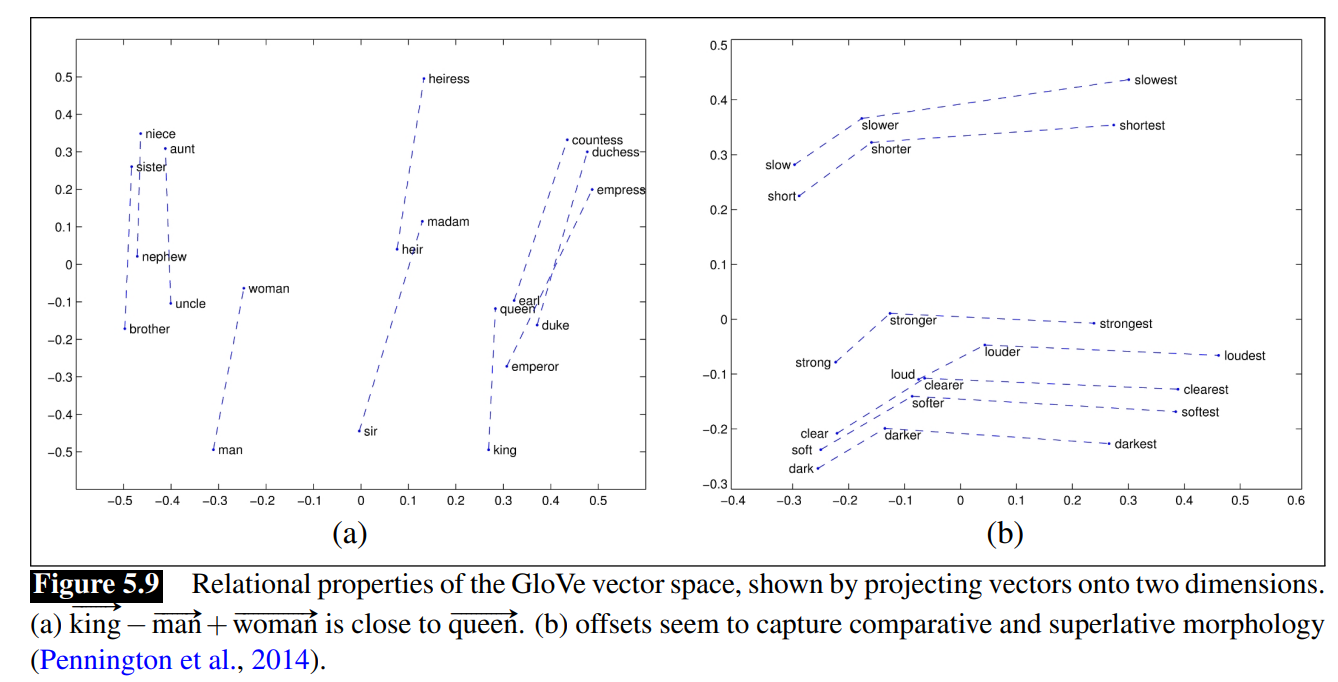

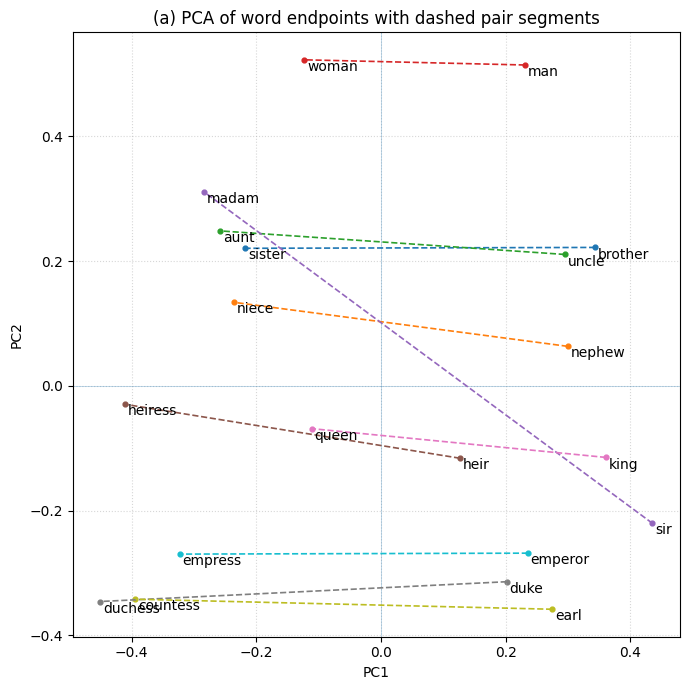

In [9]:
pairs = [
    ("brother", "sister"),
    ("nephew", "niece"),
    ("uncle", "aunt"),
    ("man", "woman"),
    ("sir", "madam"),
    ("heir", "heiress"),
    ("king", "queen"),
    ("duke", "duchess"),
    ("earl", "countess"),
    ("emperor", "empress"),
]

# 1) collect all endpoints (use unit vectors)
words = [w for pair in pairs for w in pair]
X = np.stack([emb.unit_vectors[emb.word2idx[w]] for w in words])   # (20, 50)

# 2) PCA -> 2D on the endpoints
pca = PCA(n_components=2, random_state=2025)
X2 = pca.fit_transform(X)   # (20, 2)

# 3) build a mapping word -> 2D point
P = {w: X2[i] for i, w in enumerate(words)}

# 4) plot: dashed blue segments between each pair, label both ends
plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.axhline(0, lw=0.5, alpha=0.4)
ax.axvline(0, lw=0.5, alpha=0.4)

for (w1, w2) in pairs:
    x1, y1 = P[w1]
    x2, y2 = P[w2]
    # dashed segment
    plt.plot([x1, x2], [y1, y2], linestyle="--", linewidth=1.2)
    # tiny markers at endpoints
    plt.scatter([x1, x2], [y1, y2], s=12)

    # labels (slight offset so they don't sit on the marker)
    plt.annotate(w1, (x1, y1), xytext=(2, -8), textcoords="offset points")
    plt.annotate(w2, (x2, y2), xytext=(2, -8), textcoords="offset points")

ax.set_aspect('equal', adjustable='box')
plt.title("(a) PCA of word endpoints with dashed pair segments")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

If we take the king vector and move along the woman-man vector we should end up close to queen. And we do! So in some words one could say that we shift the relation "royalty compared to male" into female space. Kind of abstract. 

## Pytorch

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [42]:
# Download training data from open datasets.
_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

training_data = Subset(_training_data, range(0, 50_000))  # Match Nielsen
val_data = Subset(_training_data, range(50_000, 60_000))  # Match Nielsen
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(784, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.327757  [   64/50000]
loss: 2.313456  [ 6464/50000]
loss: 2.340886  [12864/50000]
loss: 2.306557  [19264/50000]
loss: 2.354456  [25664/50000]
loss: 2.352265  [32064/50000]
loss: 2.277581  [38464/50000]
loss: 2.325516  [44864/50000]
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.296645 

Epoch 2
-------------------------------
loss: 2.278349  [   64/50000]
loss: 2.270513  [ 6464/50000]
loss: 2.286825  [12864/50000]
loss: 2.269308  [19264/50000]
loss: 2.296174  [25664/50000]
loss: 2.297744  [32064/50000]
loss: 2.250156  [38464/50000]
loss: 2.287184  [44864/50000]
Test Error: 
 Accuracy: 20.3%, A